# Learning Objectives

- Build an LLM assistant for document-based Q&A using retrieval-augmented generation.

# Setup

In [1]:
!pip show numpy

Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRI

In [14]:
### Upgrading the package will restart the session. Also if there are errors kindly rerun the cell

!pip install numpy==2.3.4

In [2]:
!pip show chromadb

In [4]:
### We are upgrading to chromadb version 1.3.4 If there is an error rerun the cell

!pip install chromadb==1.3.4

In [7]:
### If there is an error rerun the cell


!pip install -q groq==0.34.1 \
                langchain==0.3.20 \
                langchain-community==0.3.19 \
                langchain-chroma==0.2.2

Ensure the library chromadb is latest. Run the below command

In [8]:
import chromadb

from langchain_community.embeddings import HuggingFaceEmbeddings

from langchain_chroma import Chroma

from google.colab import userdata


Below is the api key, endpoint, api version, deployment name for the chat model

In [9]:
from google.colab import userdata

### Ensure that you set the GROQ_API_KEY in the secrets section of google colab notebook

GROQ_API_KEY = userdata.get('GROQ_API_KEY')

In [10]:
from groq import Groq

client = Groq(api_key=GROQ_API_KEY)

In [11]:
model_name = 'openai/gpt-oss-120b'

 Instantiating the embedding model

In [15]:
### Before running the command ensure the numpy version is 2.3.4. If not then upgrade numpy as per previous steps in notebook.
### Then do not restart the notebook. If you restart then you will loose all loaded variables. Just click Cancel instad of Restart

embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Load the Vector Database

Since we persisted the database to to a folder, we can upload this database to this Colab instance and point a Chroma instance to this database.

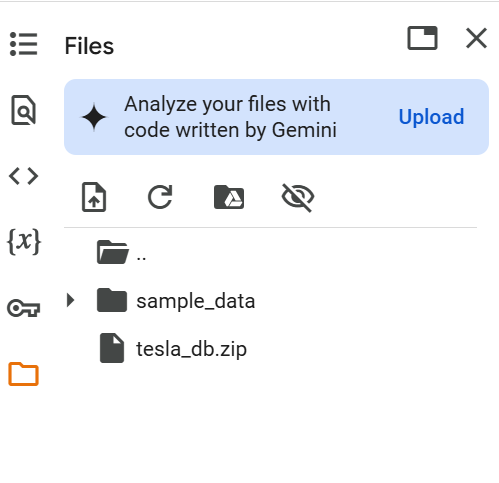

In practise, the database is maintained as a separate entity and CRUD operations are managed just as one would for normal databases (e.g., relational databases).

Now that the database is uploaded onto the Colab instance, we can unzip it and attach a retriever.

In [25]:
### Delete a folder forcefully

# !rm -rf /content/content/tesla_db

In [16]:
!unzip /content/tesla_db.zip

Archive:  /content/tesla_db.zip
   creating: tesla_db/
   creating: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/
  inflating: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/index_metadata.pickle  
  inflating: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/length.bin  
  inflating: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/data_level0.bin  
  inflating: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/header.bin  
  inflating: tesla_db/93eafe4e-70a5-4a7e-b1a6-dfe3657f77be/link_lists.bin  
  inflating: tesla_db/chroma.sqlite3  


In [17]:
chromadb_client = chromadb.PersistentClient(
    path="./tesla_db"
)

In [18]:
chromadb_client

In [19]:
tesla_10k_collection = 'tesla-10k-2019-to-2023'

In [20]:
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding,
    client=chromadb_client,
    persist_directory="./tesla_db"
)

In [21]:
retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

In [22]:
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x7ecea4043c50>, search_kwargs={'k': 5})

# RAG Q&A

## Prompt Design

The RAG system message should clearly communicate to the LLM that the input will include a user query along with the necessary context information to address that query. Additionally, the response should rely solely on the context information provided.

In [23]:
qna_system_message = """
You are an assistant to a financial services firm who answers user queries on annual reports.
User input will have the context required by you to answer user queries.
This context will be delimited by: <Context> and </Context>.
The context contains references to specific portions of a document relevant to the user query.

User queries will be delimited by: <Question> and </Question>.

Please answer user queries only using the context provided in the input.
Do not mention anything about the context in your final answer. Your response should only contain the answer to the question.

If the answer is not found in the context, respond "I don't know".
"""

In [24]:
qna_user_message_template = """
<Context>
Here are some documents that are relevant to the question mentioned below.
{context}
</Context>

<Question>
{question}
</Question>
"""

## Retrieving relevant documents

In [25]:
user_query = "What was the automotive revenue in 2021?"

In [26]:
relevant_document_chunks = retriever.invoke(user_query)

In [27]:
len(relevant_document_chunks)

5

We can inspect the first document like so:

In [28]:
for document in relevant_document_chunks:
    print(document)
    break


page_content='2022
2021
$
%
$
%
Automotive	sales
$
78,509	
$
67,210	
$
44,125	
$
11,299	
17	
%
$
23,085	
52	
%
Automotive	regulatory	credits
1,790	
1,776	
1,465	
14	
1	
%
311	
21	
%
Automotive	leasing
2,120	
2,476	
1,642	
(356)
(14)
%
834	
51	
%
Total	automotive	revenues
82,419	
71,462	
47,232	
10,957	
15	
%
24,230	
51	
%
Services	and	other
8,319	
6,091	
3,802	
2,228	
37	
%
2,289	
60	
%
Total	automotive	&	services	and	other	segment
revenue
90,738	
77,553	
51,034	
13,185	
17	
%
26,519	
52	
%
Energy	generation	and	storage	segment	revenue
6,035	
3,909	
2,789	
2,126	
54	
%
1,120	
40	
%
Total	revenues
$
96,773	
$
81,462	
$
53,823	
$
15,311	
19	
%
$
27,639	
51	
%
Automotive	&	Services	and	Other	Segment
Automotive	sales	revenue	includes	revenues	related	to	cash	and	financing	deliveries	of	new	Model	S,	Model	X,	Semi,	Model	3,	Model	Y,	and
Cybertruck	vehicles,	including	access	to	our	FSD	Capability	features	and	their	ongoing	maintenance,	internet	connectivity,	free	Supercharging	programs
and	ov

In [29]:
i = 0
for document in relevant_document_chunks:
    print(f"-------Chunk {i}-------")
    print(document.page_content.replace("\t", " "))

    i += 1

-------Chunk 0-------
2022
2021
$
%
$
%
Automotive sales
$
78,509 
$
67,210 
$
44,125 
$
11,299 
17 
%
$
23,085 
52 
%
Automotive regulatory credits
1,790 
1,776 
1,465 
14 
1 
%
311 
21 
%
Automotive leasing
2,120 
2,476 
1,642 
(356)
(14)
%
834 
51 
%
Total automotive revenues
82,419 
71,462 
47,232 
10,957 
15 
%
24,230 
51 
%
Services and other
8,319 
6,091 
3,802 
2,228 
37 
%
2,289 
60 
%
Total automotive & services and other segment
revenue
90,738 
77,553 
51,034 
13,185 
17 
%
26,519 
52 
%
Energy generation and storage segment revenue
6,035 
3,909 
2,789 
2,126 
54 
%
1,120 
40 
%
Total revenues
$
96,773 
$
81,462 
$
53,823 
$
15,311 
19 
%
$
27,639 
51 
%
Automotive & Services and Other Segment
Automotive sales revenue includes revenues related to cash and financing deliveries of new Model S, Model X, Semi, Model 3, Model Y, and
Cybertruck vehicles, including access to our FSD Capability features and their ongoing maintenance, internet connectivity, free Supercharging program

## Composing the response

To compose the response to user queries, we assemble the prompt that uses the system message defined above and the dynamically retrieved context for the user query.

In [30]:
user_query = "What was the automotive revenue in 2021?"

In [31]:

model_name = 'openai/gpt-oss-120b'

relevant_document_chunks = retriever.invoke(user_query)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = "\n---\n".join(context_list)

prompt = [
    {'role': 'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_query
        )
    }
]


try:
    response = client.chat.completions.create(
        model=model_name,
        messages=prompt,
        temperature=0
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

The automotive revenue in 2021 was **$47,232 million**.


# A RAG Assistant

Let us put together the code in this notebook into a file `rag-chat.py` that will open up a basic command line chat interface whenever it is run at the terminal. This naive implementation neverthless illustrates how document Q&A could be automated.

In [32]:
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [33]:
%%writefile rag-chat.py
import os
import chromadb

from groq import Groq

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma

model_name = 'openai/gpt-oss-120b'
tesla_10k_collection = 'tesla-10k-2019-to-2023'



###----------------------------- Chat Model ---------------------

client = Groq()

###------------------------------Embedding Model -----------------

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

###------------------------------Chroma DB Client -----------------

chromadb_client = chromadb.PersistentClient(
    path="./tesla_db"
)

vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory="./tesla_db"
)

retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

qna_system_message = """
You are an assistant to a financial services firm who answers user queries on annual reports.
User input will have the context required by you to answer user queries.
This context will be delimited by: <Context> and </Context>.
The context contains references to specific portions of a document relevant to the user query.

User queries will be delimited by: <Question> and </Question>.

Please answer user queries only using the context provided in the input.
Do not mention anything about the context in your final answer. Your response should only contain the answer to the question.

If the answer is not found in the context, respond "I don't know".
"""

qna_user_message_template = """
<Context>
Here are some documents that are relevant to the question mentioned below.
{context}
</Context>

<Question>
{question}
</Question>
"""

def respond(user_query):
    relevant_document_chunks = retriever.invoke(user_query)
    context_list = [d.page_content for d in relevant_document_chunks]
    context_for_query = "\n---\n".join(context_list)

    prompt = [
        {'role': 'system', 'content': qna_system_message},
        {
            'role': 'user', 'content': qna_user_message_template.format(
             context=context_for_query,
             question=user_query)
        }
    ]

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=prompt,
            temperature=0
        )

        answer = response.choices[0].message.content.strip()
    except Exception as e:
        answer = f'Sorry, I encountered the following error: \n {e}'

    return answer

def main():
    """
    Runs the main interactive loop for the Q&A system.

    This function initializes the conversation history, continuously prompts
    the user for queries, processes the queries using the `respond` function,
    and displays the assistant's responses. It also maintains the
    conversation history for context.

    Args:
        None

    Returns:
        None
    """

    # 1. Initialize conversation history.
    # This list stores the conversation between the user and the assistant.
    # It starts with a system message introducing the assistant's role.
    conversation_history = [
        {'role': 'system', 'content': 'You are a helpful assistant who answers queries on financial documents'}
    ]

    # 2. Enter the interactive loop.
    # The loop continues until the user enters 'q' to quit.
    while True:
        # 2.1 Get user input.
        # Prompt the user to enter a query and store it in `user_query`.
        user_query = input("User (type q to quit): ")

        # 2.2 Check for quit condition.
        # If the user enters 'q', break out of the loop.
        if user_query == 'q':
            break

        # 2.3 Process the query and get the answer.
        # Call the `respond` function to process the user query and get the answer.
        answer = respond(user_query)

        # 2.4 Update conversation history.
        # Add the user's query and the assistant's answer to the conversation history.
        conversation_history.append({'role': 'user', 'content': user_query})
        conversation_history.append({'role': 'assistant', 'content': answer})

        # 2.5 Display the assistant's answer.
        # Print the assistant's answer to the console.
        print(f"Assistant: {answer}")

        print("----- Below is the conversation history -----")
        print(conversation_history)

if __name__ == "__main__":
    main()

Writing rag-chat.py


Test Queries:

Irrelevant

- What was the total revenue of the company in 2022?

Relevant

- What was the automotive revenue in 2021?
- Summarize 5 key risks identified in the 2023 10k report? Respond with bullet point summaries.
- What is the view of the management on the future of electric vehicle batteries?
- What was the company's debt level in 2023?

In [34]:
!python rag-chat.py

/content/rag-chat.py:20: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
2025-12-10 20:12:18.418607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765397538.445043    3345 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765397538.453439    3345 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to regis

<font size=6; color='blue'> **Happy Learning!** </font>
___